In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os

from tqdm import trange

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from modules.models.baselines import static_stat_forecast, rolling_stat_forecast, ewm_forecast
from modules.diagnostics.visualizers import visualize_forecast_horizon_accuracy
from modules.diagnostics.metrics import compute_rmse
from modules.data_handling.data_splitters import split_time_series_df, tabularize_time_series

In [7]:
x = np.arange(10)
np.array_split(x, 3)

[array([0, 1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])]

# Constants

In [8]:
TRAINING_END_DATE = "2016-01-01"

DATA_FOLDER = "data"
GHI_FILE = "irradiance.csv"
WEATHER_FORECAST_FILES = [
    "nam_lat38.579454_lon121.260320.csv"
]
SATELLITE_FILE = "satellite.csv"

# Data Loading

In [9]:
ghi_df = pd.read_csv(os.path.join(DATA_FOLDER, GHI_FILE), parse_dates=["timeStamp"])
idx = pd.date_range(ghi_df["timeStamp"].min(), ghi_df["timeStamp"].max(), freq="1min")
ghi_df = ghi_df.set_index("timeStamp") 
ghi_df = ghi_df.reindex(idx, fill_value=0)
ghi_df = ghi_df.reset_index().rename({"index": "time"}, axis=1)

weather_df = []
for weather_forecast_file in WEATHER_FORECAST_FILES:
    
    weather_df.append(pd.read_csv(os.path.join(DATA_FOLDER, weather_forecast_file)))
    

weather_df = pd.concat(weather_df, ignore_index=True)

saletllite_df = pd.read_csv(os.path.join(DATA_FOLDER, SATELLITE_FILE), header=None)

# Data Preparation I

# Data Exploration

## Quality Check

## Characteristics

## Modelling Preparation

# Data Preparation II

# Modelling

In [15]:
start_date = pd.to_datetime(TRAINING_END_DATE)

ground_truth = []
forecasts = []

for step in trange(5000):

    insample_df, outsample_df = split_time_series_df(
        df=ghi_df,
        start_date=start_date,
        time_column="time",
        steps_ahead=30,
        resolution="m"
    )

    start_date += pd.to_timedelta(30, unit="m")

    insample_series = insample_df["ghi"].values
    outsample_series = outsample_df["ghi"].values

    insample_forecast, outsample_forecast = ewm_forecast(
        time_series=insample_series,
        steps_ahead=30,
        alpha=0.5,
    )

    ground_truth.append(outsample_series)
    forecasts.append(outsample_forecast)

ground_truth = np.array(ground_truth)
forecasts = np.array(forecasts)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [06:56<00:00, 12.00it/s]


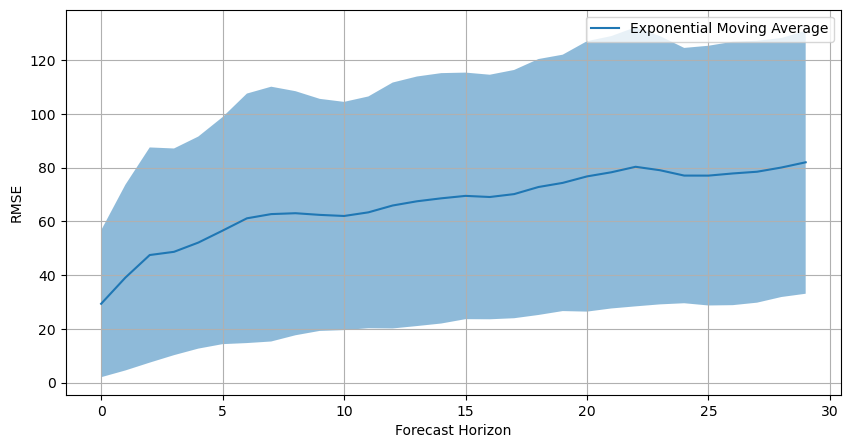

In [16]:
error_mean, error_sem = compute_rmse(
    y_true=ground_truth,
    y_forecast=forecasts,
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Exponential Moving Average",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem
)
plt.legend()
plt.show()